In [ ]:
import pandas as pd

# List of file paths
file_paths = ['/content/sample_data/synchronized1_bvp_features_final.csv',
              '/content/sample_data/synchronized4_bvp_features_final.csv',
              '/content/sample_data/synchronized5_bvp_features_final.csv',
              '/content/sample_data/synchronized8_bvp_features_final.csv',
              '/content/sample_data/synchronized9_bvp_features_final.csv',
              '/content/sample_data/synchronized10_bvp_features_final.csv',
              '/content/sample_data/synchronized11_bvp_features_final.csv',
              '/content/sample_data/synchronized12_bvp_features_final.csv',
              '/content/sample_data/synchronized13_bvp_features_final.csv',
              '/content/sample_data/synchronized14_bvp_features_final.csv',
              '/content/sample_data/synchronized15_bvp_features_final.csv',
              '/content/sample_data/synchronized16_bvp_features_final.csv',
              '/content/sample_data/synchronized17_bvp_features_final.csv',
              '/content/sample_data/synchronized19_bvp_features_final.csv',
              '/content/sample_data/synchronized20_bvp_features_final.csv',
              '/content/sample_data/synchronized21_bvp_features_final.csv',
              '/content/sample_data/synchronized22_bvp_features_final.csv',
              '/content/sample_data/synchronized23_bvp_features_final.csv',
              '/content/sample_data/synchronized24_bvp_features_final.csv',
              '/content/sample_data/synchronized25_bvp_features_final.csv',
              '/content/sample_data/synchronized26_bvp_features_final.csv',
              '/content/sample_data/synchronized27_bvp_features_final.csv',
              '/content/sample_data/synchronized28_bvp_features_final.csv',
              '/content/sample_data/synchronized29_bvp_features_final.csv',
              '/content/sample_data/synchronized30_bvp_features_final.csv',
              '/content/sample_data/synchronized31_bvp_features_final.csv',

]

In [ ]:
# Function to merge multiple CSV files into a single DataFrame
def merge_csv_files(file_paths):
    # Initialize an empty list to hold dataframes
    dataframes = []

    # Iterate over the file paths and read each CSV file
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dataframes.append(df)

    # Concatenate all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df

In [ ]:
# Merge the files
merged_df = merge_csv_files(file_paths)

In [ ]:

# Remove empty rows
df_cleaned = merged_df.dropna(how='all')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.utils import resample

In [ ]:
# Load the dataset
file_path = '/content/sample_data/merged_synchronized2_data (1).csv'
df = pd.read_csv(file_path)

In [ ]:
# Calculate the mean only for numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [ ]:
# Select only the specified columns as features
feature_columns = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD',
    'SampEn', 'Number_of_SCRs', 'Summed_Magnitude_of_SCRs',
    'Summed_Area_Under_SCRs', 'Mean_Tonic_Level', 'Std_Tonic_Level',
    'Mean_Phasic_Activity', 'Number_of_Responses', 'Skewness_y', 'Kurtosis_y', 'AVNN', 'CV', 'SDNN', 'RMSSD', 'SDSD'
]

In [ ]:
X = df[feature_columns]  # Features
y = df['a-v']  # Target (valence/arousal)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Combine the training data back into a dataframe for upsampling
train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
classes = [train_df[train_df['a-v'] == label] for label in y_train.value_counts().index]
max_count = y_train.value_counts().max()

In [ ]:
classes_upsampled = [
    resample(cls, replace=True, n_samples=max_count, random_state=42) if len(cls) < max_count else cls
    for cls in classes
]

In [ ]:
# Combine the upsampled classes into a single dataframe
train_df_upsampled = pd.concat(classes_upsampled)

In [ ]:
# Shuffle the resulting dataframe
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check the distribution of the 'emotion' column after upsampling
upsampled_class_counts = train_df_upsampled['a-v'].value_counts()
upsampled_class_counts

,count
a-v,
valence,1610
arousal,1610


In [ ]:
# Separate the features and the target variable again
X_train_upsampled = train_df_upsampled[feature_columns]
y_train_upsampled = train_df_upsampled['a-v']

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train a Random Forest Classifier to get feature importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_upsampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

In [ ]:
# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

     arousal       0.60      0.33      0.43       316
     valence       0.75      0.90      0.81       690

    accuracy                           0.72      1006
   macro avg       0.67      0.61      0.62      1006
weighted avg       0.70      0.72      0.69      1006



In [ ]:
# Get feature importances
feature_importances = clf.feature_importances_

In [ ]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

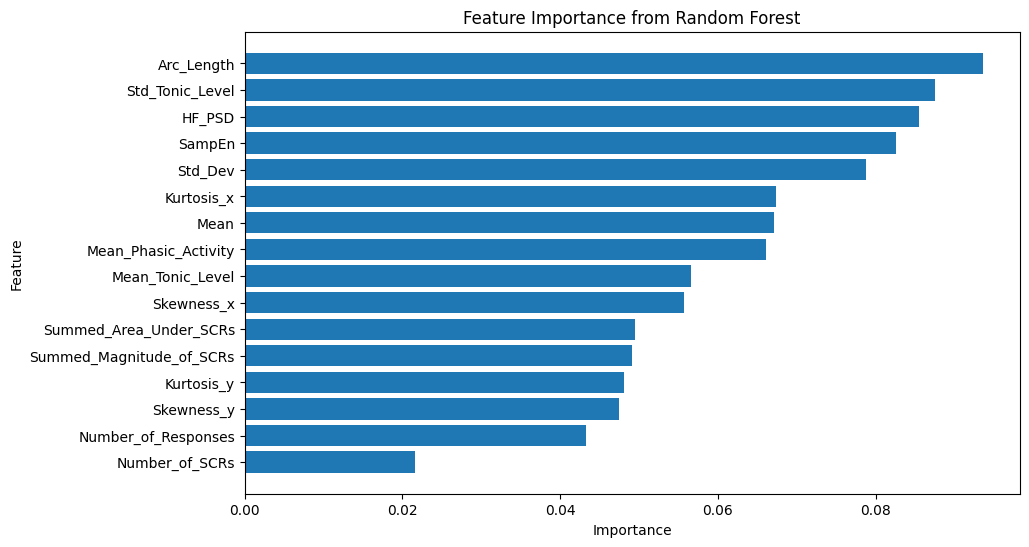

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Select top features based on importance
top_features = feature_importance_df['Feature'][:10].tolist()
X_train_top = X_train_scaled[:, :len(top_features)]
X_test_top = X_test_scaled[:, :len(top_features)]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': np.arange(3, 8),
    'min_samples_split': [2, 5, 10]
}

In [ ]:
# Initialize the model
gbc = GradientBoostingClassifier(random_state=42)

In [ ]:
# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(gbc, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train_top, y_train_upsampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': array([3, 4, 5, 6, 7]),
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [ ]:
# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_gbc = random_search.best_estimator_

In [ ]:
# Make predictions on the test set
y_pred = best_gbc.predict(X_test_top)


In [ ]:
# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       angry       0.38      0.18      0.24        79
    cheerful       0.19      0.11      0.14       103
       happy       0.47      0.69      0.56       379
     nervous       0.36      0.30      0.33       305
     neutral       0.39      0.32      0.35       126
         sad       0.00      0.00      0.00        14

    accuracy                           0.41      1006
   macro avg       0.30      0.26      0.27      1006
weighted avg       0.38      0.41      0.39      1006



# **BVP+EDA with RF , XGBOOST , MLP** **EMOTION**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight # Import the missing function

In [ ]:
# Load the dataset
file_path = '/content/sample_data/merged_synchronized2_data (1).csv'
df = pd.read_csv(file_path)

In [ ]:
# Replace missing values in each column with the mean of that specific column
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [ ]:
# Filter out the "sad" class from the dataset
df_filtered = df[df['emotion'] != 'sad']

In [ ]:
# Select the features and the target
feature_columns = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD',
    'SampEn', 'Number_of_SCRs', 'Summed_Magnitude_of_SCRs',
    'Summed_Area_Under_SCRs', 'Mean_Tonic_Level', 'Std_Tonic_Level',
    'Mean_Phasic_Activity', 'Number_of_Responses', 'Skewness_y', 'Kurtosis_y'
]

In [ ]:
X = df_filtered[feature_columns]  # Features
y = df_filtered['emotion']  # Target

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Compute the correlation matrix
corr_matrix = X_train.corr()

In [ ]:
# Identify features to drop due to high correlation
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

In [ ]:
print(f"Features to drop due to high correlation: {to_drop}")

Features to drop due to high correlation: ['Arc_Length', 'Summed_Area_Under_SCRs']


In [ ]:
# Drop the highly correlated features from X_train and X_test
X_train_dropped = X_train.drop(columns=to_drop)
X_test_dropped = X_test.drop(columns=to_drop)

In [ ]:
# Combine the training data back into a dataframe for upsampling
train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
# Upsample the minority classes in the training set
classes = [train_df[train_df['emotion'] == label] for label in y_train.value_counts().index]
max_count = y_train.value_counts().max()

In [ ]:
classes_upsampled = [
    resample(cls, replace=True, n_samples=max_count, random_state=42) if len(cls) < max_count else cls
    for cls in classes
]

In [ ]:
# Combine the upsampled classes into a single dataframe
train_df_upsampled = pd.concat(classes_upsampled)

In [ ]:
# Shuffle the resulting dataframe
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check the distribution of the 'emotion' column after upsampling
upsampled_class_counts = train_df_upsampled['emotion'].value_counts()
upsampled_class_counts

,count
emotion,
nervous,882
cheerful,882
angry,882
happy,882
neutral,882


In [ ]:
# Separate features and target from upsampled data
X_train_upsampled = train_df_upsampled[feature_columns]
y_train_upsampled = train_df_upsampled['emotion']

In [ ]:
# Encode the target variable
le = LabelEncoder()
y_train_upsampled_encoded = le.fit_transform(y_train_upsampled)
y_test_encoded = le.transform(y_test)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)  # Assuming X_test is already defined

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_upsampled_encoded)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test set
y_pred = rf.predict(X_test_scaled)

In [ ]:
# Evaluate the model's performance
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.29      0.37        79
           1       0.33      0.18      0.24       103
           2       0.49      0.76      0.60       379
           3       0.61      0.34      0.43       305
           4       0.45      0.45      0.45       126

    accuracy                           0.49       992
   macro avg       0.48      0.41      0.42       992
weighted avg       0.50      0.49      0.47       992



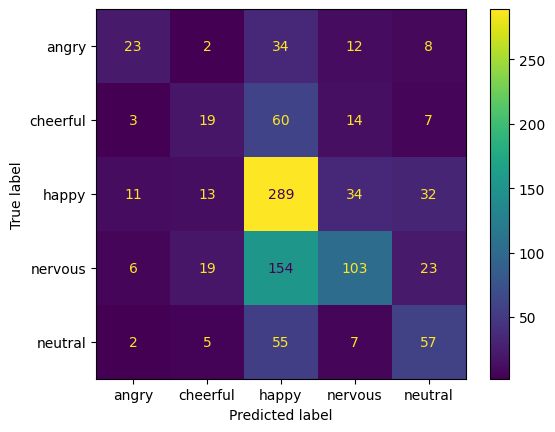

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Generate the confusion matrix
rf_cm = confusion_matrix(y_test_encoded, y_pred)

# Display the confusion matrix
ConfusionMatrixDisplay(rf_cm, display_labels=le.classes_).plot()

# Show the plot
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Initialize and fit LabelEncoder (assuming 'y' is your target variable)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Replace 'y' with your actual target variable

In [ ]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the MLP model
model.fit(X_train_scaled, y_train_upsampled_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
111/111 - 2s - 16ms/step - accuracy: 0.2075 - loss: 1.7822 - val_accuracy: 0.2483 - val_loss: 1.5962
Epoch 2/50
111/111 - 0s - 3ms/step - accuracy: 0.2449 - loss: 1.6353 - val_accuracy: 0.2857 - val_loss: 1.5793
Epoch 3/50
111/111 - 0s - 2ms/step - accuracy: 0.2800 - loss: 1.6052 - val_accuracy: 0.3039 - val_loss: 1.5708
Epoch 4/50
111/111 - 0s - 2ms/step - accuracy: 0.2650 - loss: 1.5980 - val_accuracy: 0.3390 - val_loss: 1.5652
Epoch 5/50
111/111 - 0s - 3ms/step - accuracy: 0.2840 - loss: 1.5709 - val_accuracy: 0.3764 - val_loss: 1.5486
Epoch 6/50
111/111 - 0s - 3ms/step - accuracy: 0.3024 - loss: 1.5542 - val_accuracy: 0.3776 - val_loss: 1.5373
Epoch 7/50
111/111 - 0s - 2ms/step - accuracy: 0.3075 - loss: 1.5494 - val_accuracy: 0.3787 - val_loss: 1.5274
Epoch 8/50
111/111 - 0s - 3ms/step - accuracy: 0.3192 - loss: 1.5396 - val_accuracy: 0.3764 - val_loss: 1.5163
Epoch 9/50
111/111 - 0s - 2ms/step - accuracy: 0.3228 - loss: 1.5303 - val_accuracy: 0.3980 - val_loss: 1.5002


In [ ]:
# Predict on the test set using MLP
y_pred_probs = model.predict(X_test_scaled)
y_pred = y_pred_probs.argmax(axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Evaluate the MLP model's performance
from sklearn.metrics import classification_report, confusion_matrix
print("Simplified MLP Model Performance")
print(classification_report(y_test_encoded, y_pred))
print(confusion_matrix(y_test_encoded, y_pred))

Simplified MLP Model Performance
              precision    recall  f1-score   support

           0       0.21      0.44      0.29        79
           1       0.15      0.32      0.21       103
           2       0.55      0.33      0.41       379
           3       0.51      0.29      0.37       305
           4       0.32      0.52      0.40       126

    accuracy                           0.35       992
   macro avg       0.35      0.38      0.33       992
weighted avg       0.44      0.35      0.37       992

[[ 35  11   9   9  15]
 [ 10  33  23  16  21]
 [ 62  91 125  45  56]
 [ 49  69  51  89  47]
 [  9  13  21  17  66]]


In [ ]:
# Calculate the confusion matrix
mlp_cm = confusion_matrix(y_test_encoded, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(mlp_cm)


Confusion Matrix:
[[ 35  11   9   9  15]
 [ 10  33  23  16  21]
 [ 62  91 125  45  56]
 [ 49  69  51  89  47]
 [  9  13  21  17  66]]


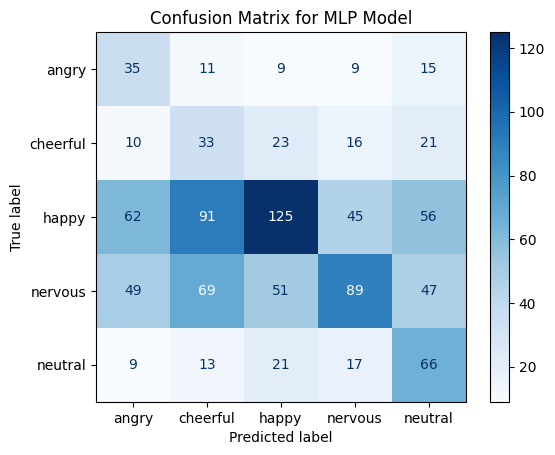

In [ ]:
# Display the confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MLP Model")
plt.show()

In [ ]:
# Print the overall accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

Overall Accuracy: 0.35


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Define and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_upsampled_encoded)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict on the test set using XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
# Print the classification report for XGBoost model
print("XGBoost Model Performance:")
print(classification_report(y_test_encoded, y_pred_xgb))

# Calculate the confusion matrix for XGBoost model
xgb_cm = confusion_matrix(y_test_encoded, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(xgb_cm)

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.37      0.25      0.30        79
           1       0.29      0.20      0.24       103
           2       0.50      0.70      0.58       379
           3       0.50      0.38      0.43       305
           4       0.48      0.39      0.43       126

    accuracy                           0.47       992
   macro avg       0.43      0.38      0.40       992
weighted avg       0.46      0.47      0.46       992

Confusion Matrix:
[[ 35  11   9   9  15]
 [ 10  33  23  16  21]
 [ 62  91 125  45  56]
 [ 49  69  51  89  47]
 [  9  13  21  17  66]]


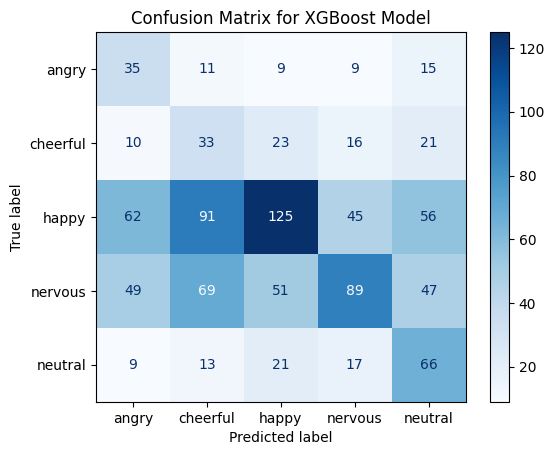

In [ ]:
# Display the confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

# **BVP+EDA with A-V**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import compute_class_weight
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Replace missing values in each column with the mean of that specific column
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())


In [ ]:
# Select the features and the target
feature_columns = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD',
    'SampEn', 'Number_of_SCRs', 'Summed_Magnitude_of_SCRs',
    'Summed_Area_Under_SCRs', 'Mean_Tonic_Level', 'Std_Tonic_Level',
    'Mean_Phasic_Activity', 'Number_of_Responses', 'Skewness_y', 'Kurtosis_y'
]

In [ ]:
X = df[feature_columns]  # Features
y = df['a-v']  # Target (using 'a-v' column)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Combine the training data to address class imbalance through upsampling
train_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
# Upsample the minority class
majority_class = train_data['a-v'].value_counts().idxmax()
upsampled_train_data = []


In [ ]:
for label in y_train.value_counts().index:
    label_data = train_data[train_data['a-v'] == label]
    upsampled_label_data = resample(label_data, replace=True, n_samples=y_train.value_counts().max(), random_state=42)
    upsampled_train_data.append(upsampled_label_data)

In [ ]:
# Combine the upsampled data
train_data_upsampled = pd.concat(upsampled_train_data)

In [ ]:
# Separate the features and target from the upsampled data
X_train_upsampled = train_data_upsampled[feature_columns]
y_train_upsampled = train_data_upsampled['a-v']

In [ ]:
upsampled_class_counts = y_train_upsampled.value_counts()

In [ ]:
# Display the distribution
print("Class distribution after upsampling:")
print(upsampled_class_counts)

Class distribution after upsampling:
a-v
valence    1610
arousal    1610
Name: count, dtype: int64


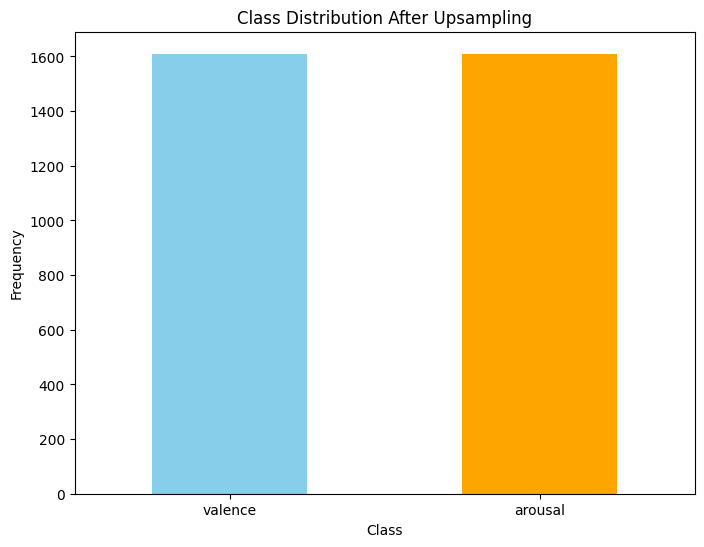

In [ ]:
# Visualize the class distribution using a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
upsampled_class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution After Upsampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Label encoding for the target labels (0 and 1)
label_encoder = LabelEncoder()
y_train_upsampled_encoded = label_encoder.fit_transform(y_train_upsampled)
y_test_encoded = label_encoder.transform(y_test)

# ----------- Simplified MLP Model -----------

In [ ]:
# Compute initial class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_upsampled_encoded), y=y_train_upsampled_encoded)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Adjust class weights more conservatively
class_weights[0] = 1.0
class_weights[1] = 1.0

In [ ]:
# ----------- Define and Train the MLP Model with Adjusted Class Weights -----------
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the MLP model with more balanced class weights
history = model.fit(X_train_scaled, y_train_upsampled_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=2, class_weight=class_weights)

Epoch 1/50
81/81 - 3s - 32ms/step - accuracy: 0.5928 - loss: 1.0940 - val_accuracy: 0.0202 - val_loss: 1.2620
Epoch 2/50
81/81 - 0s - 4ms/step - accuracy: 0.6048 - loss: 1.0256 - val_accuracy: 0.0233 - val_loss: 1.1980
Epoch 3/50
81/81 - 0s - 2ms/step - accuracy: 0.5982 - loss: 0.9768 - val_accuracy: 0.0171 - val_loss: 1.1525
Epoch 4/50
81/81 - 0s - 4ms/step - accuracy: 0.6110 - loss: 0.9296 - val_accuracy: 0.0140 - val_loss: 1.1115
Epoch 5/50
81/81 - 0s - 4ms/step - accuracy: 0.6161 - loss: 0.8878 - val_accuracy: 0.0000e+00 - val_loss: 1.0970
Epoch 6/50
81/81 - 0s - 4ms/step - accuracy: 0.6238 - loss: 0.8516 - val_accuracy: 0.0000e+00 - val_loss: 1.0773
Epoch 7/50
81/81 - 0s - 3ms/step - accuracy: 0.6200 - loss: 0.8224 - val_accuracy: 0.0000e+00 - val_loss: 1.0590
Epoch 8/50
81/81 - 0s - 3ms/step - accuracy: 0.6238 - loss: 0.7998 - val_accuracy: 0.0000e+00 - val_loss: 1.0451
Epoch 9/50
81/81 - 0s - 4ms/step - accuracy: 0.6223 - loss: 0.7772 - val_accuracy: 0.0000e+00 - val_loss: 1.032

In [ ]:
# Predict on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Print the classification report for MLP model
print("MLP Model Performance with Balanced Class Weights:")
print(classification_report(y_test_encoded, y_pred))

# Calculate the confusion matrix for MLP model
mlp_cm = confusion_matrix(y_test_encoded, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(mlp_cm)


MLP Model Performance with Balanced Class Weights:
              precision    recall  f1-score   support

           0       0.45      0.03      0.05       316
           1       0.69      0.98      0.81       690

    accuracy                           0.68      1006
   macro avg       0.57      0.51      0.43      1006
weighted avg       0.61      0.68      0.57      1006

Confusion Matrix:
[[  9 307]
 [ 11 679]]


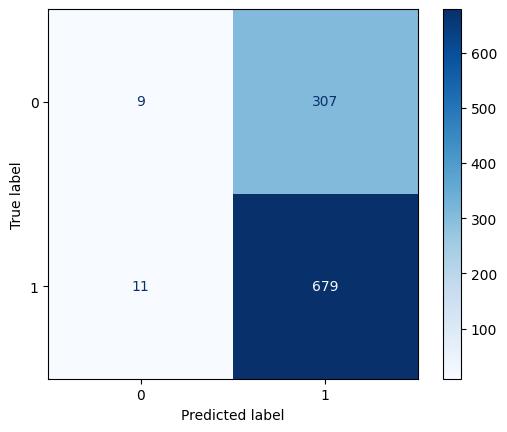

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test_encoded and y_pred are already defined
labels_to_consider = np.unique(y_test_encoded)

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred, labels=labels_to_consider)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_consider)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
labels_to_consider = np.unique(y_test_encoded)
confusion_matrix(y_test_encoded, y_pred, labels=labels_to_consider)

array([[  9, 307],
       [ 11, 679]])

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Calculate scale_pos_weight (ratio of negative to positive samples)
neg_samples = sum(y_train_upsampled_encoded == 0)
pos_samples = sum(y_train_upsampled_encoded == 1)

# If there are multiple classes, you can calculate this for the majority and minority classes
scale_pos_weight = neg_samples / pos_samples

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, scale_pos_weight]


In [ ]:
# Initialize XGBoost without use_label_encoder
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

In [ ]:
# Fit the model to the training data
xgb_model.fit(X_train_scaled, y_train_upsampled_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=1)

In [ ]:
# Fit the model
grid_search.fit(X_train_scaled, y_train_upsampled_encoded)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 1.0]},
             scoring='f1', verbose=2)

In [ ]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}


In [ ]:
# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

In [ ]:
# Print performance metrics
print("XGBoost Model Performance after Tuning")
print(classification_report(y_test_encoded, y_pred_xgb))
print(confusion_matrix(y_test_encoded, y_pred_xgb))

XGBoost Model Performance after Tuning
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       316
           1       0.72      0.73      0.73       690

    accuracy                           0.62      1006
   macro avg       0.55      0.55      0.55      1006
weighted avg       0.61      0.62      0.62      1006

[[117 199]
 [184 506]]


XGBoost Model Performance after Tuning
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       316
           1       0.72      0.73      0.73       690

    accuracy                           0.62      1006
   macro avg       0.55      0.55      0.55      1006
weighted avg       0.61      0.62      0.62      1006



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).

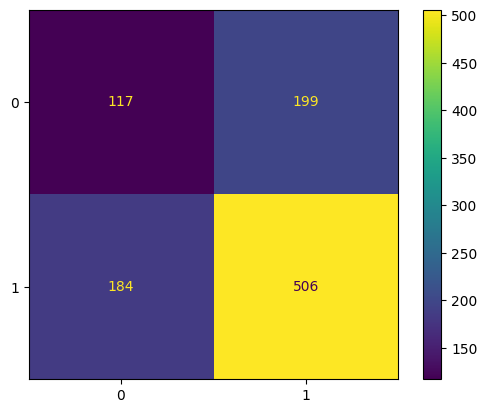

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Print performance metrics
print("XGBoost Model Performance after Tuning")
print(classification_report(y_test_encoded, y_pred_xgb))

# Generate the confusion matrix
xgb_cm = confusion_matrix(y_test_encoded, y_pred_xgb)

# Display the confusion matrix
ConfusionMatrixDisplay(xgb_cm, display_labels=le.classes_).plot()

# Show the plot
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [ ]:
# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=1
)


In [ ]:
# Fit the model
random_search_rf.fit(X_train_scaled, y_train_upsampled_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, class_weight=None, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimato

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [ ]:
# Predict on the test set
y_pred = random_search_rf.predict(X_test_scaled)

In [ ]:
# Evaluate the model's performance
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.51      0.44       316
           1       0.74      0.63      0.68       690

    accuracy                           0.59      1006
   macro avg       0.56      0.57      0.56      1006
weighted avg       0.63      0.59      0.61      1006



Random Forest Model Performance after RandomizedSearchCV Tuning
              precision    recall  f1-score   support

           0       0.39      0.51      0.44       316
           1       0.74      0.63      0.68       690

    accuracy                           0.59      1006
   macro avg       0.56      0.57      0.56      1006
weighted avg       0.63      0.59      0.61      1006



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).

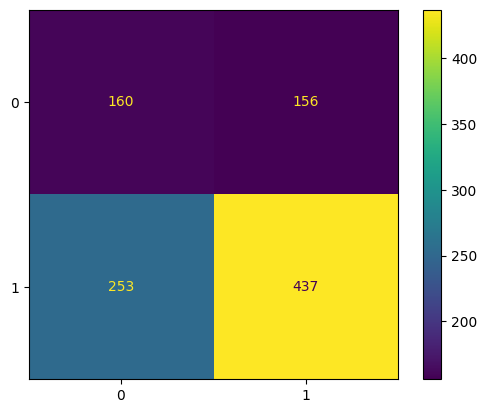

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = random_search_rf.predict(X_test_scaled)

# Evaluate the model's performance
print("Random Forest Model Performance after RandomizedSearchCV Tuning")
print(classification_report(y_test_encoded, y_pred))

# Generate and display the confusion matrix
rf_cm = confusion_matrix(y_test_encoded, y_pred)
ConfusionMatrixDisplay(rf_cm, display_labels=le.classes_).plot()

# Show the plot
plt.show()

# **BVP+EDA+HR-RATE with emotion **

# random forest and xgboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
file_path = '/content/sample_data/merged_synchronized2_data (1) (1).csv'
df = pd.read_csv(file_path)

In [ ]:
# Print the distribution of classes in the 'emotion' column before dropping values
class_distribution_before_dropping = df['emotion'].value_counts()

In [ ]:
# Print the distribution
print("Class distribution in the 'emotion' column before dropping values:")
print(class_distribution_before_dropping)

Class distribution in the 'emotion' column before dropping values:
emotion
happy       1261
nervous     1017
neutral      420
cheerful     344
angry        264
sad           45
Name: count, dtype: int64


In [ ]:
# Ensure datetime conversion for timestamp_x column
df['timestamp_x'] = pd.to_datetime(df['timestamp_x'], format='%d/%m/%Y %H:%M')

In [ ]:
# Extract time-based features from timestamp_x
df['hour'] = df['timestamp_x'].dt.hour
df['minute'] = df['timestamp_x'].dt.minute
df['second'] = df['timestamp_x'].dt.second

In [ ]:
# Calculate elapsed time from the start for each participant using timestamp_x
df['elapsed_time'] = df.groupby('pid')['seconds'].transform(lambda x: x - x.min())

In [ ]:
# Creating lag features for key physiological signals
df['Mean_lag_1'] = df.groupby('pid')['Mean'].shift(1)
df['Std_Dev_lag_1'] = df.groupby('pid')['Std_Dev'].shift(1)
df['Arc_Length_lag_1'] = df.groupby('pid')['Arc_Length'].shift(1)

In [ ]:
# Fill NaN values in lag features with the corresponding original feature value
df['Mean_lag_1'].fillna(df['Mean'], inplace=True)
df['Std_Dev_lag_1'].fillna(df['Std_Dev'], inplace=True)
df['Arc_Length_lag_1'].fillna(df['Arc_Length'], inplace=True)

In [ ]:
# Replace empty (NaN) values in numeric columns with the mean of their respective columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [ ]:
# Print the distribution of classes in the 'emotion' column before dropping values
class_distribution_before_dropping = df['emotion'].value_counts()

In [ ]:
# Print the distribution
print("Class distribution in the 'emotion' column before dropping values:")
print(class_distribution_before_dropping)

Class distribution in the 'emotion' column before dropping values:
emotion
happy       1261
nervous     1017
neutral      420
cheerful     344
angry        264
sad           45
Name: count, dtype: int64


In [ ]:
# Remove classes with only one sample in the target variable
class_counts = df['emotion'].value_counts()
classes_to_keep = class_counts[class_counts > 1].index
df = df[df['emotion'].isin(classes_to_keep)]

In [ ]:
# Define the features before and after feature engineering
features = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD', 'SampEn',
    'Number_of_SCRs', 'Summed_Magnitude_of_SCRs', 'Summed_Area_Under_SCRs',
    'Mean_Tonic_Level', 'Std_Tonic_Level', 'Mean_Phasic_Activity', 'Number_of_Responses',
    'Skewness_y', 'Kurtosis_y', 'AVNN', 'CV', 'SDNN', 'RMSSD', 'SDSD',
    'Mean_lag_1', 'Std_Dev_lag_1', 'Arc_Length_lag_1'
]
target = 'emotion'

In [ ]:
# Check for constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
print(f"Constant features: {constant_features}")

NameError: name 'X_train' is not defined

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[features].corr()

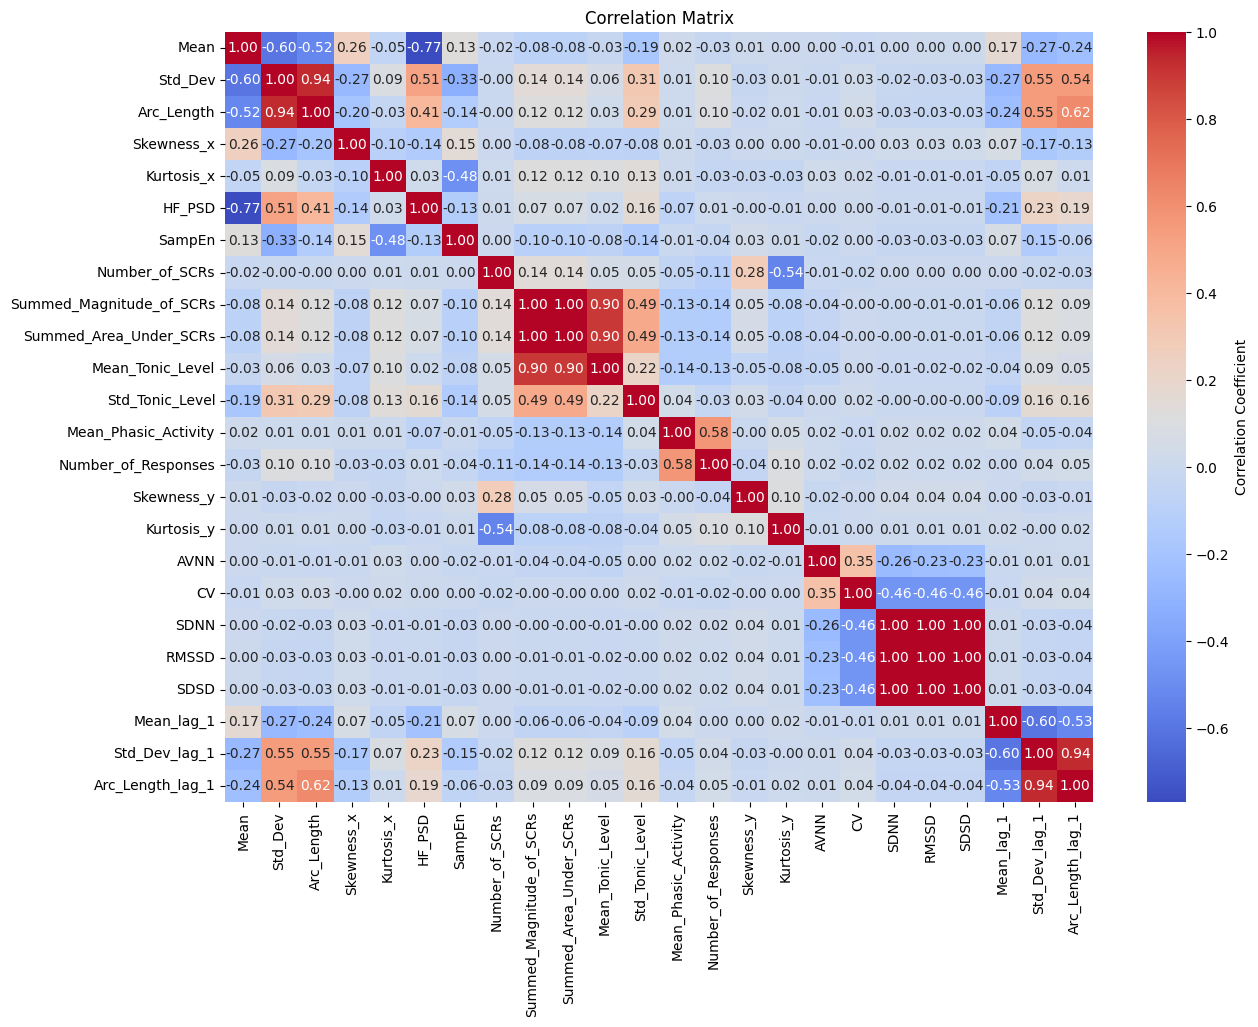

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Removing highly correlated features
threshold = 0.75
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

In [ ]:
# Dropping the features
df_reduced = df.drop(columns=to_drop)

In [ ]:
# Update the features list to only include those that remain
features_reduced = [feature for feature in features if feature not in to_drop]

# Recalculate the correlation matrix after removal
reduced_corr_matrix = df_reduced[features_reduced].corr()

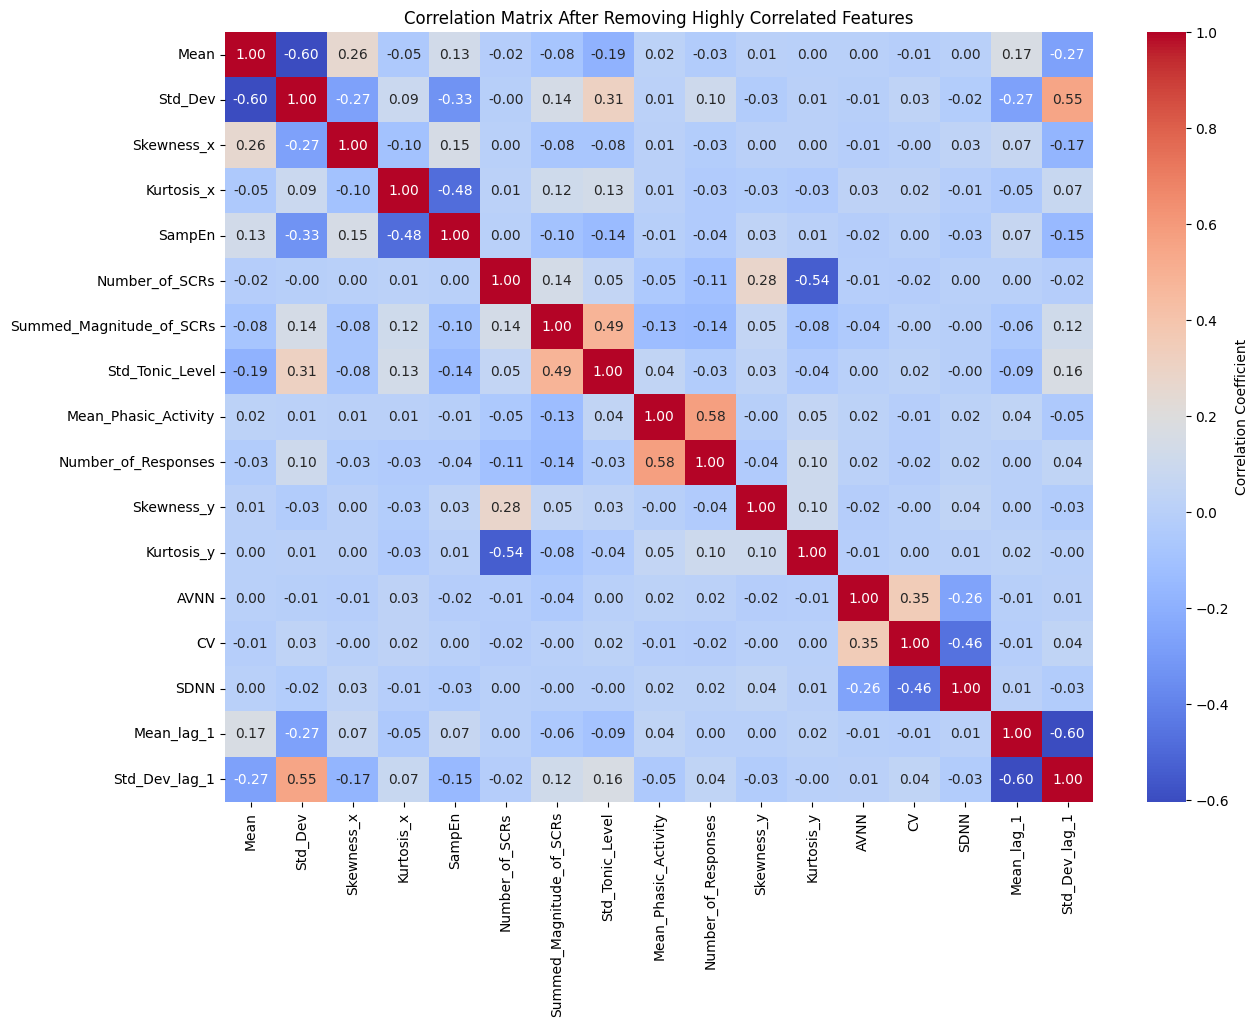

In [ ]:
# Plot the reduced correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(reduced_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix After Removing Highly Correlated Features")
plt.show()

In [ ]:
# Optional: Calculate VIF to further check multicollinearity
X = sm.add_constant(df_reduced[features_reduced])
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
# Display VIF values
print("Variance Inflation Factor (VIF):")
print(vif)

Variance Inflation Factor (VIF):
                    Features        VIF
0                      const  53.484867
1                       Mean   1.638390
2                    Std_Dev   2.543545
3                 Skewness_x   1.113271
4                 Kurtosis_x   1.342167
5                     SampEn   1.494009
6             Number_of_SCRs   1.684065
7   Summed_Magnitude_of_SCRs   1.389957
8            Std_Tonic_Level   1.462221
9       Mean_Phasic_Activity   1.547873
10       Number_of_Responses   1.562913
11                Skewness_y   1.203987
12                Kurtosis_y   1.560459
13                      AVNN   1.164107
14                        CV   1.375845
15                      SDNN   1.296933
16                Mean_lag_1   1.603725
17             Std_Dev_lag_1   2.179270


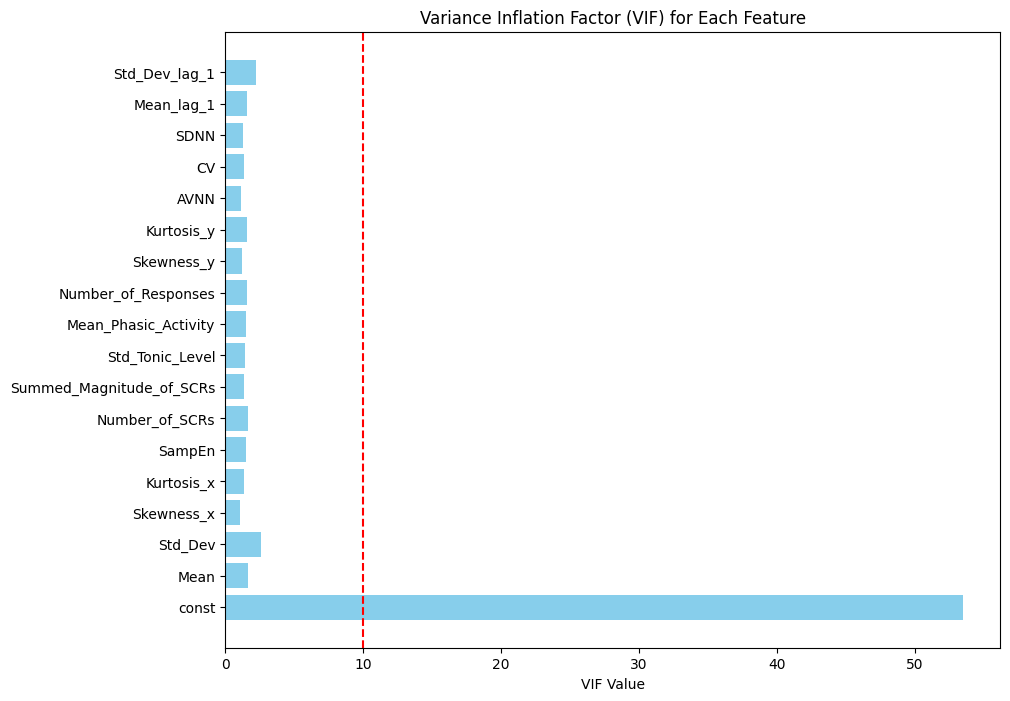

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your VIF data in a DataFrame
vif_data = pd.DataFrame({
    'Features': ['const', 'Mean', 'Std_Dev', 'Skewness_x', 'Kurtosis_x', 'SampEn',
                 'Number_of_SCRs', 'Summed_Magnitude_of_SCRs', 'Std_Tonic_Level',
                 'Mean_Phasic_Activity', 'Number_of_Responses', 'Skewness_y',
                 'Kurtosis_y', 'AVNN', 'CV', 'SDNN', 'Mean_lag_1', 'Std_Dev_lag_1'],
    'VIF': [53.508096, 1.645217, 2.607476, 1.111661, 1.343254, 1.493133,
            1.684089, 1.391005, 1.463104, 1.546378, 1.562543, 1.204158,
            1.560208, 1.164117, 1.375805, 1.296945, 1.608214, 2.230607]
})

# Create bar plot
plt.figure(figsize=(10, 8))
plt.barh(vif_data['Features'], vif_data['VIF'], color='skyblue')
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF) for Each Feature')
plt.axvline(x=10, color='red', linestyle='--')  # Adding a line to indicate VIF = 10 threshold
plt.show()

In [ ]:
# Split the data into training and testing sets
X = df_reduced[features_reduced]
y = df_reduced[target]

In [ ]:
# Remove the "sad" class
df_filtered = df[df['emotion'] != 'sad']

In [ ]:
# Update features and target
X_filtered = df_filtered[features]
y_filtered = df_filtered['emotion']

In [ ]:
# Encode the target labels as integers
label_encoder = LabelEncoder()
y_filtered_encoded = label_encoder.fit_transform(y_filtered)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered_encoded, test_size=0.2, random_state=42, stratify=y_filtered_encoded)

In [ ]:
# Perform SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Check the distribution of classes after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
3    1009
2    1009
4    1009
0    1009
1    1009
Name: count, dtype: int64


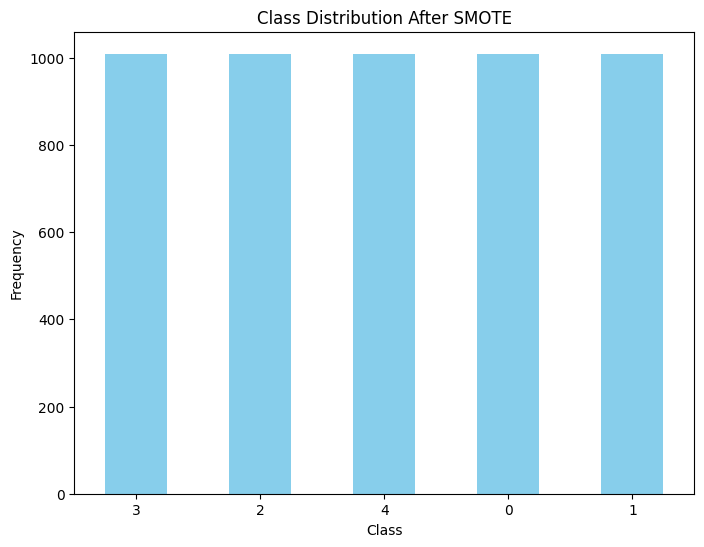

In [ ]:
# Visualize the class distribution after SMOTE
plt.figure(figsize=(8, 6))
pd.Series(y_train_smote).value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set up the XGBoost classifier with hyperparameter tuning
xgb = XGBClassifier(random_state=42)

In [ ]:
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                   n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=1)


In [ ]:
random_search.fit(X_train_scaled, y_train_smote)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Make predictions on the test set
y_pred = random_search.predict(X_test_scaled)

In [ ]:
# Decode the predicted labels back to the original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
report = classification_report(y_test_decoded, y_pred_decoded)

In [ ]:
# Print the results
print(f'Best Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.6389728096676737
Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.36      0.42        53
    cheerful       0.52      0.32      0.40        69
       happy       0.66      0.75      0.70       252
     nervous       0.63      0.68      0.65       204
     neutral       0.70      0.67      0.68        84

    accuracy                           0.64       662
   macro avg       0.61      0.55      0.57       662
weighted avg       0.63      0.64      0.63       662



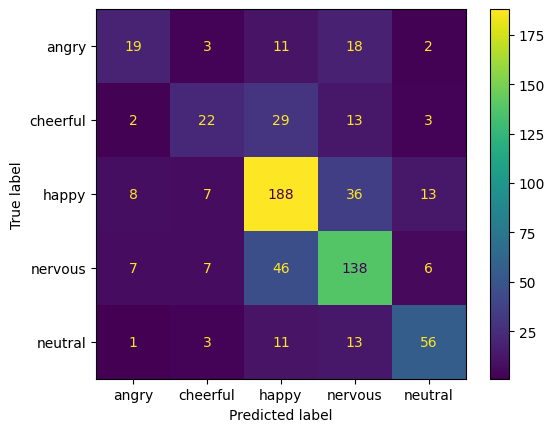

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded)

# Display the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot()

# Show the plot
plt.show()

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Set up RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist,
                                      n_iter=20, cv=3, scoring='accuracy',
                                      random_state=42, n_jobs=1)

In [ ]:
# Fit the model
random_search_rf.fit(X_train_scaled, y_train_smote)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Make predictions on the test set
y_pred_rf = random_search_rf.predict(X_test_scaled)

In [ ]:
# Decode the predicted labels back to the original labels
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)
y_test_decoded = label_encoder.inverse_transform(y_test)

In [ ]:
# Now evaluate the model
accuracy_rf = accuracy_score(y_test_decoded, y_pred_rf_decoded)
report_rf = classification_report(y_test_decoded, y_pred_rf_decoded)

In [ ]:
# Print the results
print(f'Best Parameters for Random Forest: {random_search_rf.best_params_}')
print(f'Accuracy with Random Forest: {accuracy_rf}')
print('Classification Report for Random Forest:')
print(report_rf)

Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
Accuracy with Random Forest: 0.6601208459214502
Classification Report for Random Forest:
              precision    recall  f1-score   support

       angry       0.53      0.38      0.44        53
    cheerful       0.41      0.26      0.32        69
       happy       0.70      0.81      0.75       252
     nervous       0.65      0.68      0.67       204
     neutral       0.73      0.68      0.70        84

    accuracy                           0.66       662
   macro avg       0.60      0.56      0.58       662
weighted avg       0.65      0.66      0.65       662



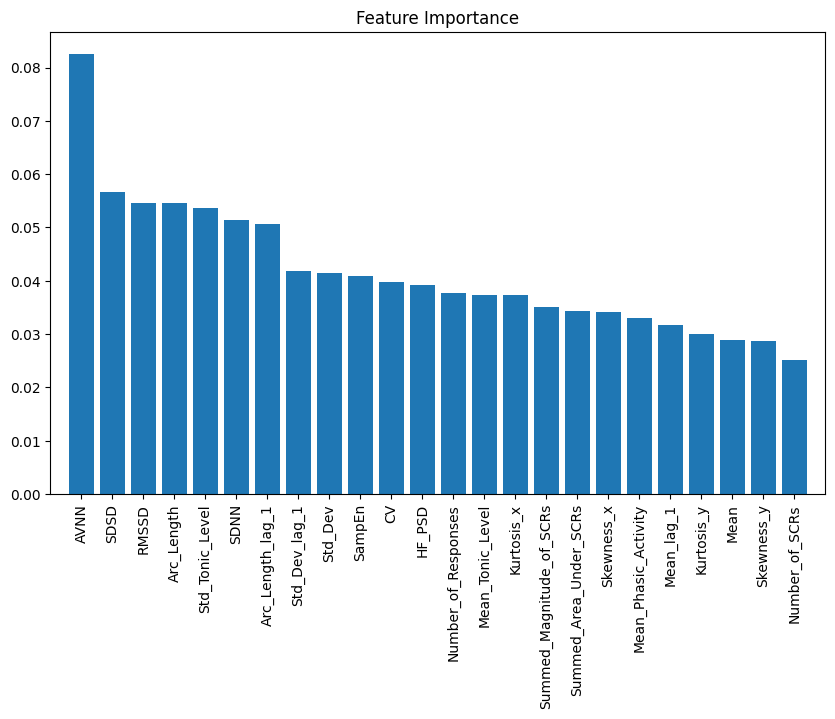

In [ ]:
importances = random_search_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

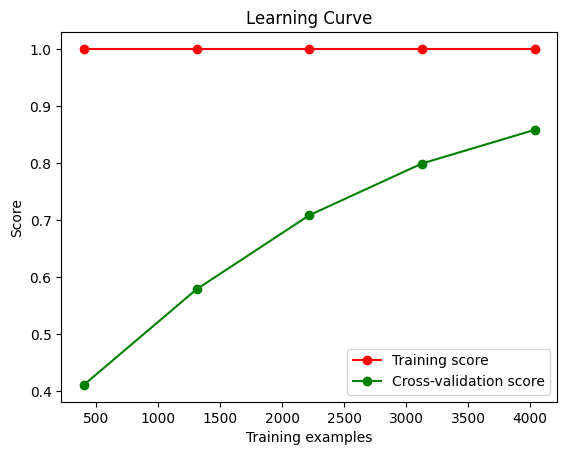

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    random_search_rf.best_estimator_, X_train_scaled, y_train_smote, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

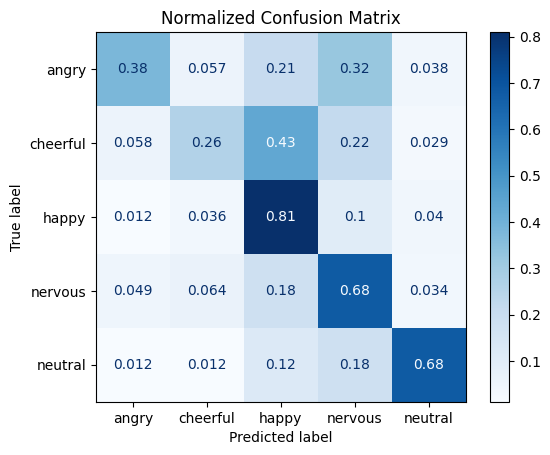

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(cm_normalized, display_labels=label_encoder.classes_).plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

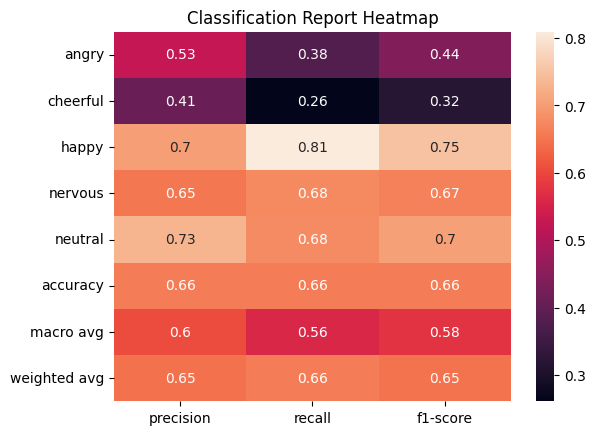

In [ ]:
import seaborn as sns
report = classification_report(y_test_decoded, y_pred_rf_decoded, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report Heatmap')
plt.show()

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_rf_decoded)

# Display the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot()

# Show the plot
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

# **BVP+EDA+HR a-v**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Print the distribution of classes in the 'a-v' column before dropping values
class_distribution_before_dropping = df['a-v'].value_counts()

In [ ]:
 # Print the distribution
print("Class distribution in the 'emotion' column before dropping values:")
print(class_distribution_before_dropping)

Class distribution in the 'emotion' column before dropping values:
a-v
valence    2300
arousal    1051
Name: count, dtype: int64


In [ ]:
  # Ensure datetime conversion for timestamp_x column
df['timestamp_x'] = pd.to_datetime(df['timestamp_x'], format='%d/%m/%Y %H:%M')

In [ ]:
 # Extract time-based features from timestamp_x
df['hour'] = df['timestamp_x'].dt.hour
df['minute'] = df['timestamp_x'].dt.minute
df['second'] = df['timestamp_x'].dt.second

In [ ]:
  # Calculate elapsed time from the start for each participant using timestamp_x
df['elapsed_time'] = df.groupby('pid')['seconds'].transform(lambda x: x - x.min())

In [ ]:
# Creating lag features for key physiological signals
df['Mean_lag_1'] = df.groupby('pid')['Mean'].shift(1)
df['Std_Dev_lag_1'] = df.groupby('pid')['Std_Dev'].shift(1)
df['Arc_Length_lag_1'] = df.groupby('pid')['Arc_Length'].shift(1)

In [ ]:
# Fill NaN values in lag features with the corresponding original feature value
df['Mean_lag_1'].fillna(df['Mean'], inplace=True)
df['Std_Dev_lag_1'].fillna(df['Std_Dev'], inplace=True)
df['Arc_Length_lag_1'].fillna(df['Arc_Length'], inplace=True)

In [ ]:
# Replace empty (NaN) values in numeric columns with the mean of their respective columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [ ]:
# Print the distribution of classes in the 'emotion' column before dropping values
class_distribution_before_dropping = df['a-v'].value_counts()

In [ ]:
# Print the distribution
print("Class distribution in the 'a-v' column before dropping values:")
print(class_distribution_before_dropping)

Class distribution in the 'a-v' column before dropping values:
a-v
valence    2300
arousal    1051
Name: count, dtype: int64


In [ ]:
# Define initial features and target
features = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD', 'SampEn',
    'Number_of_SCRs', 'Summed_Magnitude_of_SCRs', 'Summed_Area_Under_SCRs',
    'Mean_Tonic_Level', 'Std_Tonic_Level', 'Mean_Phasic_Activity', 'Number_of_Responses',
    'Skewness_y', 'Kurtosis_y', 'AVNN', 'CV', 'SDNN', 'RMSSD', 'SDSD',
    'Mean_lag_1', 'Std_Dev_lag_1', 'Arc_Length_lag_1'
]
target = 'a-v'

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[features].corr()

In [ ]:
# Removing highly correlated features
threshold = 0.75
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]


In [ ]:
# Dropping the features from the original dataframe
df_reduced = df.drop(columns=to_drop)

In [ ]:
# Update the features list to only include those that remain
features_reduced = [feature for feature in features if feature not in to_drop]

In [ ]:
# Recalculate the correlation matrix after removal
reduced_corr_matrix = df_reduced[features_reduced].corr()

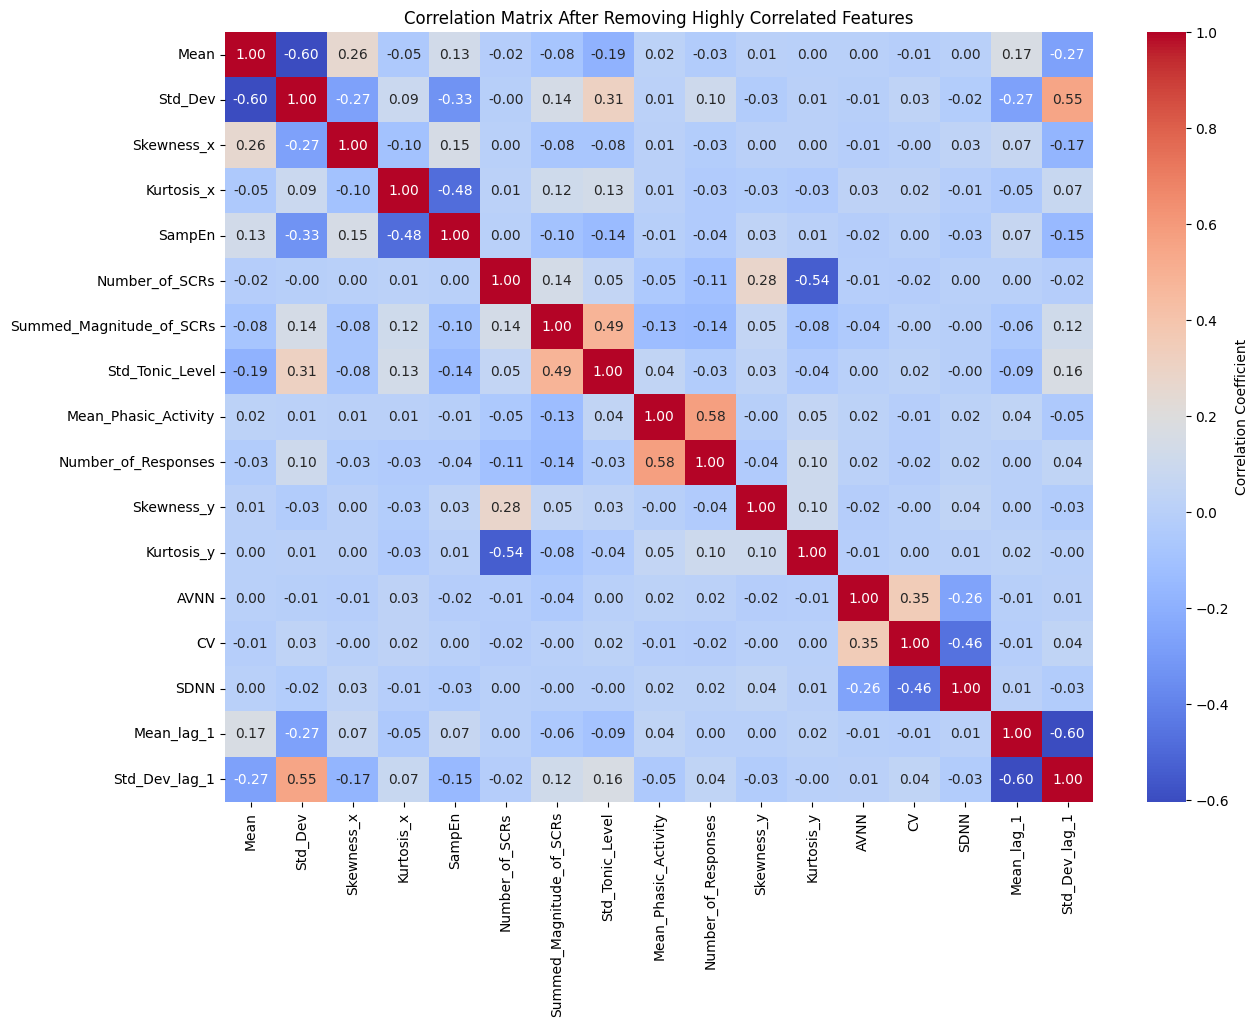

In [ ]:
# Plot the reduced correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(reduced_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix After Removing Highly Correlated Features")
plt.show()

In [ ]:
# Split the data into training and testing sets
X = df_reduced[features_reduced]
y = df_reduced[target]

In [ ]:
# Encode the target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Check the distribution of classes after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
1    1839
0    1839
Name: count, dtype: int64


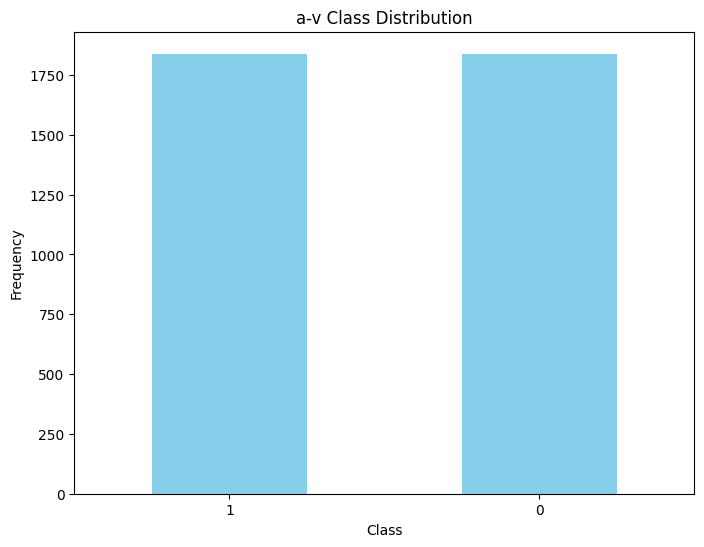

In [ ]:
# Visualize the class distribution after SMOTE
plt.figure(figsize=(8, 6))
pd.Series(y_train_smote).value_counts().plot(kind='bar', color='skyblue')
plt.title('a-v Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist,
                                      n_iter=20, cv=3, scoring='accuracy',
                                      random_state=42, n_jobs=1)

In [ ]:
# Fit the model
random_search_rf.fit(X_train_scaled, y_train_smote)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Make predictions on the test set
y_pred_rf = random_search_rf.predict(X_test_scaled)

In [ ]:
# Decode the predicted labels back to the original labels
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)
y_test_decoded = label_encoder.inverse_transform(y_test)

In [ ]:
# Evaluate the model's performance
accuracy_rf = classification_report(y_test_decoded, y_pred_rf_decoded)
print("Random Forest with SMOTE Performance")
print(accuracy_rf)

Random Forest with SMOTE Performance
              precision    recall  f1-score   support

     arousal       0.60      0.49      0.54       210
     valence       0.78      0.85      0.82       461

    accuracy                           0.74       671
   macro avg       0.69      0.67      0.68       671
weighted avg       0.73      0.74      0.73       671



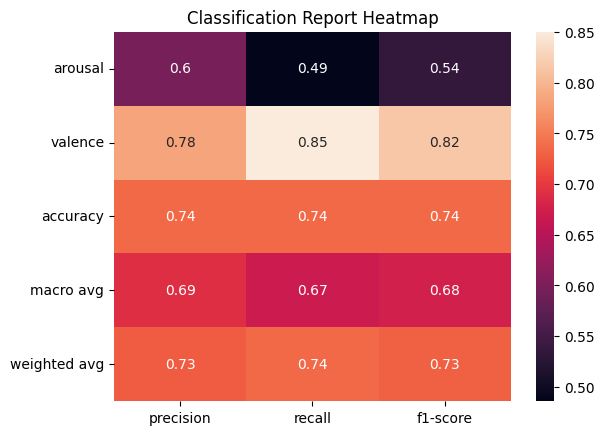

In [ ]:
import seaborn as sns
report = classification_report(y_test_decoded, y_pred_rf_decoded, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report Heatmap')
plt.show()

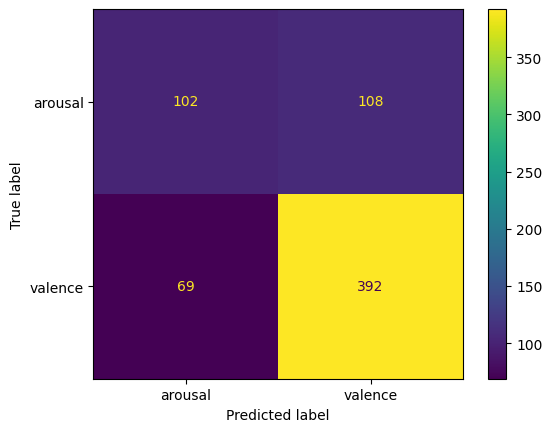

In [ ]:
# Generate the confusion matrix
cm_rf = confusion_matrix(y_test_decoded, y_pred_rf_decoded)

# Display the confusion matrix
ConfusionMatrixDisplay(cm_rf, display_labels=label_encoder.classes_).plot()

# Show the plot
plt.show()

In [ ]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
selected_features = [features_reduced[i] for i in indices]

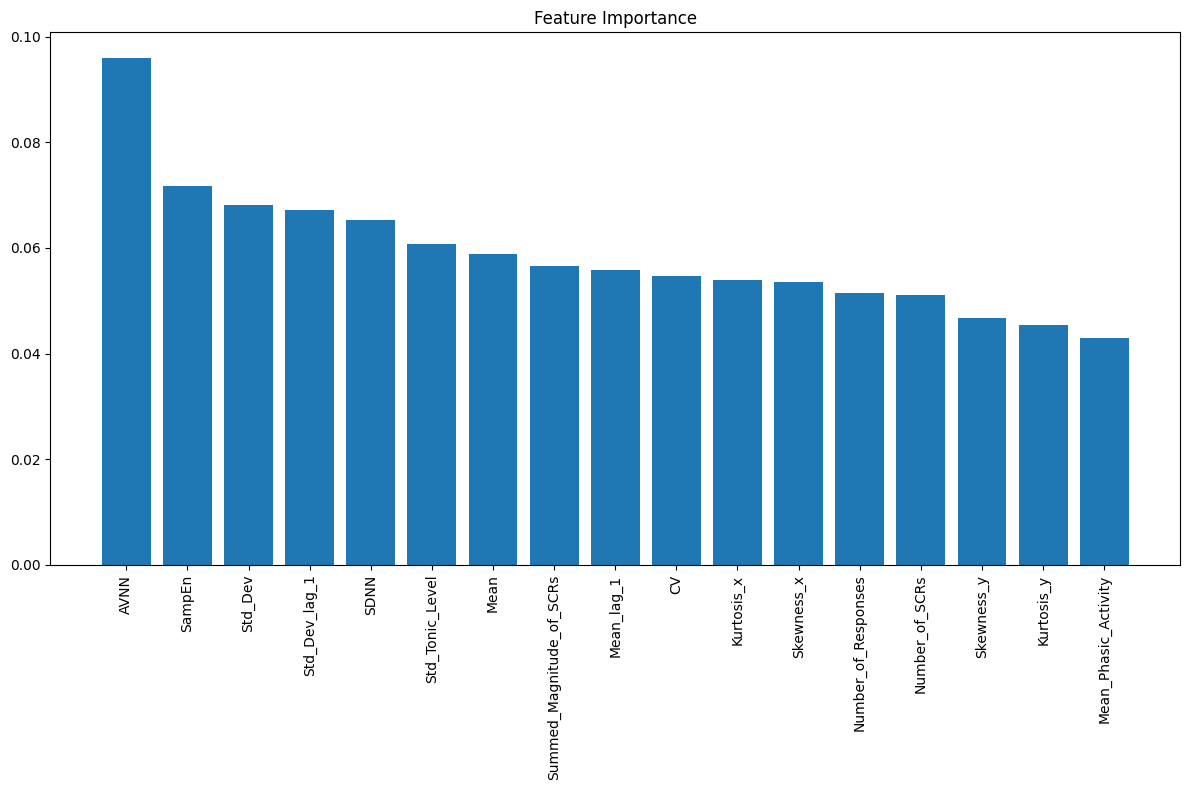

In [ ]:
# Plotting Feature Importance
plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(len(features_reduced)), importances[indices], align="center")
plt.xticks(range(len(features_reduced)), selected_features, rotation=90)
plt.tight_layout()
plt.show()

# **XGBOOST**

In [ ]:
# Train an XGBoost model
xgb_model = XGBClassifier(random_state=42)

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=1)
random_search.fit(X_train_scaled, y_train_smote)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Best parameters found by RandomizedSearchCV
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
# Make predictions on the test set
y_pred = random_search.predict(X_test_scaled)

In [ ]:
# Decode the predicted labels back to the original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

In [ ]:
# Evaluate the model
accuracy = classification_report(y_test_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy}')

Accuracy:               precision    recall  f1-score   support

     arousal       0.59      0.50      0.54       210
     valence       0.79      0.84      0.81       461

    accuracy                           0.73       671
   macro avg       0.69      0.67      0.68       671
weighted avg       0.73      0.73      0.73       671



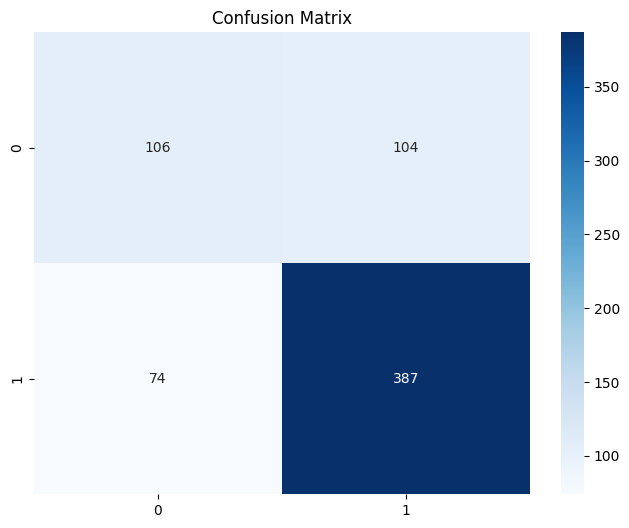

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf # Import tensorflow

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = BinaryCrossentropy()(y_true, y_pred)
        y_true = tf.cast(y_true, dtype=tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_pred) - y_pred)
        fl = alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * bce
        return fl
    return focal_loss_fixed

In [ ]:

def create_model():
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model()

In [ ]:
# Compile the model with a smaller learning rate and Focal Loss
model.compile(optimizer=Adam(learning_rate=0.0005), loss=focal_loss(), metrics=['accuracy'])

In [ ]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train_smote,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights_dict,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                    verbose=2)

Epoch 1/150
92/92 - 4s - 47ms/step - accuracy: 0.5146 - loss: 0.1306 - val_accuracy: 0.6671 - val_loss: 0.1165
Epoch 2/150
92/92 - 0s - 3ms/step - accuracy: 0.5279 - loss: 0.1088 - val_accuracy: 0.7351 - val_loss: 0.0996
Epoch 3/150
92/92 - 1s - 7ms/step - accuracy: 0.5170 - loss: 0.1073 - val_accuracy: 0.7677 - val_loss: 0.0910
Epoch 4/150
92/92 - 0s - 3ms/step - accuracy: 0.5065 - loss: 0.1058 - val_accuracy: 0.7310 - val_loss: 0.0958
Epoch 5/150
92/92 - 1s - 7ms/step - accuracy: 0.5160 - loss: 0.0983 - val_accuracy: 0.7255 - val_loss: 0.0957
Epoch 6/150
92/92 - 1s - 7ms/step - accuracy: 0.5258 - loss: 0.0933 - val_accuracy: 0.8030 - val_loss: 0.0834
Epoch 7/150
92/92 - 1s - 7ms/step - accuracy: 0.5221 - loss: 0.0892 - val_accuracy: 0.8546 - val_loss: 0.0755
Epoch 8/150
92/92 - 1s - 6ms/step - accuracy: 0.5214 - loss: 0.0879 - val_accuracy: 0.8451 - val_loss: 0.0767
Epoch 9/150
92/92 - 0s - 3ms/step - accuracy: 0.5272 - loss: 0.0859 - val_accuracy: 0.8668 - val_loss: 0.0744
Epoch 10/

In [ ]:
# Predicting and evaluating the model
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Decode the predicted labels back to the original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

In [ ]:
# Classification Report
print("ANN with SMOTE Performance")
print(classification_report(y_test_decoded, y_pred_decoded))

ANN with SMOTE Performance
              precision    recall  f1-score   support

     arousal       0.37      0.73      0.49       210
     valence       0.78      0.43      0.55       461

    accuracy                           0.52       671
   macro avg       0.57      0.58      0.52       671
weighted avg       0.65      0.52      0.53       671



In [ ]:
def create_simpler_model(learning_rate=0.001, dropout_rate=0.4, layer_size=64):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(layer_size, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(layer_size // 2, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Train the simpler model
simpler_model = create_simpler_model()
history = simpler_model.fit(X_train_scaled, y_train_smote, epochs=50, batch_size=16, validation_split=0.2, verbose=2)

Epoch 1/50
184/184 - 2s - 10ms/step - accuracy: 0.5799 - loss: 0.6978 - val_accuracy: 0.0041 - val_loss: 0.8901
Epoch 2/50
184/184 - 1s - 7ms/step - accuracy: 0.6071 - loss: 0.6708 - val_accuracy: 0.0041 - val_loss: 0.8770
Epoch 3/50
184/184 - 1s - 3ms/step - accuracy: 0.6213 - loss: 0.6622 - val_accuracy: 0.0027 - val_loss: 0.8942
Epoch 4/50
184/184 - 1s - 4ms/step - accuracy: 0.6230 - loss: 0.6554 - val_accuracy: 0.0041 - val_loss: 0.8901
Epoch 5/50
184/184 - 1s - 5ms/step - accuracy: 0.6278 - loss: 0.6506 - val_accuracy: 0.0109 - val_loss: 0.8829
Epoch 6/50
184/184 - 1s - 3ms/step - accuracy: 0.6281 - loss: 0.6445 - val_accuracy: 0.0421 - val_loss: 0.8711
Epoch 7/50
184/184 - 0s - 2ms/step - accuracy: 0.6258 - loss: 0.6487 - val_accuracy: 0.0476 - val_loss: 0.8644
Epoch 8/50
184/184 - 0s - 2ms/step - accuracy: 0.6319 - loss: 0.6402 - val_accuracy: 0.0530 - val_loss: 0.8970
Epoch 9/50
184/184 - 1s - 3ms/step - accuracy: 0.6431 - loss: 0.6368 - val_accuracy: 0.1046 - val_loss: 0.8625


In [ ]:
# Evaluate the model's performance on the test set
y_pred_probs = simpler_model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print("Simpler ANN Model Performance")
print(report)

Simpler ANN Model Performance
              precision    recall  f1-score   support

           0       0.53      0.16      0.24       210
           1       0.71      0.94      0.81       461

    accuracy                           0.69       671
   macro avg       0.62      0.55      0.53       671
weighted avg       0.65      0.69      0.63       671



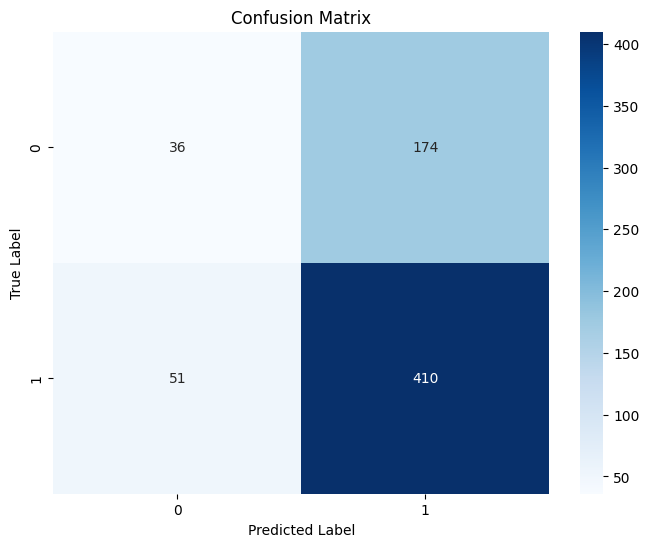

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **LOSO** validation model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Load the dataset
file_path = '/content/sample_data/merged_synchronized2_data (1) (1).csv'
df = pd.read_csv(file_path)

In [ ]:
# Exclude participants 2, 3, 6, 7, 18
excluded_pids = [2, 3, 6, 7, 18]
df = df[~df['pid'].isin(excluded_pids)]

In [ ]:
# Ensure datetime conversion for timestamp_x column
df['timestamp_x'] = pd.to_datetime(df['timestamp_x'], format='%d/%m/%Y %H:%M')

In [ ]:
# Extract time-based features from timestamp_x
df['hour'] = df['timestamp_x'].dt.hour
df['minute'] = df['timestamp_x'].dt.minute
df['second'] = df['timestamp_x'].dt.second

In [ ]:
# Calculate elapsed time from the start for each participant using timestamp_x
df['elapsed_time'] = df.groupby('pid')['seconds'].transform(lambda x: x - x.min())

In [ ]:
# Creating lag features for key physiological signals
df['Mean_lag_1'] = df.groupby('pid')['Mean'].shift(1)
df['Std_Dev_lag_1'] = df.groupby('pid')['Std_Dev'].shift(1)
df['Arc_Length_lag_1'] = df.groupby('pid')['Arc_Length'].shift(1)

In [ ]:
# Fill NaN values in lag features with the corresponding original feature value
df['Mean_lag_1'].fillna(df['Mean'], inplace=True)
df['Std_Dev_lag_1'].fillna(df['Std_Dev'], inplace=True)
df['Arc_Length_lag_1'].fillna(df['Arc_Length'], inplace=True)

In [ ]:
# Replace missing numeric values with the mean of their respective columns
from sklearn.impute import SimpleImputer

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [ ]:
# Define the features and target
features = [
    'Mean', 'Std_Dev', 'Arc_Length', 'Skewness_x', 'Kurtosis_x', 'HF_PSD', 'SampEn',
    'Number_of_SCRs', 'Summed_Magnitude_of_SCRs', 'Summed_Area_Under_SCRs',
    'Mean_Tonic_Level', 'Std_Tonic_Level', 'Mean_Phasic_Activity', 'Number_of_Responses',
    'Skewness_y', 'Kurtosis_y', 'AVNN', 'CV', 'SDNN', 'RMSSD', 'SDSD',
    'Mean_lag_1', 'Std_Dev_lag_1', 'Arc_Length_lag_1'
]
target = 'emotion'

In [ ]:
# Calculate the correlation matrix and remove highly correlated features (threshold > 0.75)
corr_matrix = df[features].corr()
threshold = 0.75
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

In [ ]:
# Drop these features from the dataset
df_reduced = df.drop(columns=to_drop)
features_reduced = [feature for feature in features if feature not in to_drop]

In [ ]:
# Filter out the 'sad' class and ensure balanced data
df_filtered = df_reduced[df_reduced['emotion'] != 'sad']

In [ ]:
# Merge similar classes using .loc to avoid SettingWithCopyWarning
df_filtered.loc[:, 'emotion'] = df_filtered['emotion'].replace({
    'cheerful': 'happy',
    'nervous': 'angry'
})


In [ ]:
# Filter the dataset to include only participants with at least one sample in at least two different classes
participant_class_counts = df_filtered.groupby('pid')['emotion'].value_counts().unstack().fillna(0)
balanced_participants = participant_class_counts[(participant_class_counts > 1).sum(axis=1) > 1].index.tolist()
df_balanced = df_filtered[df_filtered['pid'].isin(balanced_participants)]

In [ ]:
# Define features, target, and groups after filtering
X = df_balanced[features_reduced]
y = df_balanced['emotion']
groups = df_balanced['pid']

In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Set up Leave-One-Group-Out cross-validation
logo = LeaveOneGroupOut()

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Initialize RandomForestClassifier and RandomizedSearchCV
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                      n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

In [ ]:
# Lists to store results
classification_reports = []

In [ ]:
# Perform LOSO cross-validation on balanced data
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train model with RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train_smote)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Make predictions on the test set
y_pred_rf = random_search_rf.predict(X_test_scaled)

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, zero_division=0)
classification_reports.append(report)
print(f'Participant: {groups.iloc[test_index].iloc[0]} - Classification Report:\n{report}')

Participant: 31.0 - Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         0
       happy       0.89      0.58      0.71       113
     neutral       0.16      0.20      0.18        15

    accuracy                           0.54       128
   macro avg       0.35      0.26      0.29       128
weighted avg       0.81      0.54      0.64       128



In [ ]:
# Final participant counts after LOSO
print("Final participant counts:\n", groups.value_counts())

Final participant counts:
 pid
1.0     181
26.0    146
25.0    146
19.0    145
20.0    142
4.0     136
15.0    129
17.0    129
31.0    128
5.0     124
13.0    122
9.0     122
28.0    121
10.0    120
22.0    120
12.0    119
8.0     119
14.0    117
11.0    116
21.0    115
23.0    110
30.0    110
Name: count, dtype: int64


In [ ]:
# Add the encoded emotion labels back to the DataFrame for easier plotting
df_balanced['emotion_encoded'] = y_encoded

<ipython-input-131-c8e35227dceb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced['emotion_encoded'] = y_encoded


In [ ]:
# Create a pivot table to count the number of samples per class for each participant
class_counts = df_balanced.pivot_table(index='pid', columns='emotion', aggfunc='size', fill_value=0)

<Axes: xlabel='pid'>

<Figure size 1200x800 with 0 Axes>

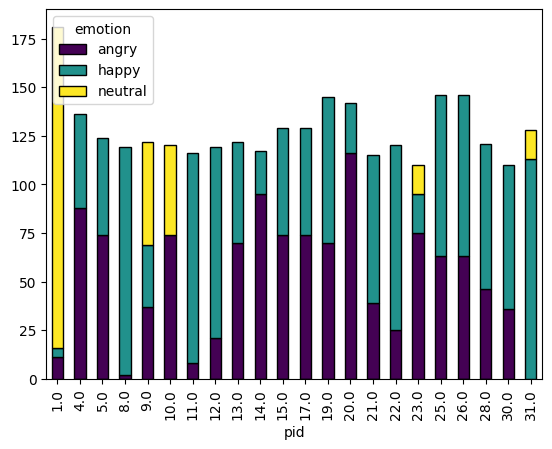

In [ ]:
# Plotting the class distribution for each participant
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', stacked=True, cmap='viridis', edgecolor='black')